# Traffic Signs Recognition
Elias Ejo | May-06-2023

## 1. Import the required libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Deep Learning
import tensorflow as tf
from keras.models import Sequential,load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard
from keras.utils import to_categorical

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

# Image processing
from PIL import Image
import os

## 2. Read the Train_data_label Excel file

### 2.1 Declaring  and initalizing location and global variables

In [2]:
# define the root directory path of dataset
path_root_data = '..\\Dataset_Traffic_Signs_Recognition\\data\\'

# define the location of Train dataset
path_train_data = os.path.join(path_root_data, 'Train\\')

# define the location of Test dataset
path_test_data  = os.path.join(path_root_data, 'Test\\' )

# define the size of our images
image_size = (30 , 30)

# Folder name that store our logs
log_dir = 'Logs'

# Folder name that store our models
model_dir = 'Models'

### 2.2 Reading train data labels

In [3]:
# Load train data labels
ds_train_data_label = pd.read_csv(os.path.join(path_root_data, "Train_data_label.csv"))

In [4]:
# Load image class labels
ds_class_label = pd.read_csv(os.path.join(path_root_data, "Class_label.csv"))

In [5]:
# Load test data labels
ds_test_data_label = pd.read_csv(os.path.join(path_root_data, "Test_data_label.csv"))

In [6]:
print(ds_train_data_label.shape, ds_test_data_label.shape, ds_class_label.shape)

(39209, 2) (12630, 2) (43, 2)


In [7]:
# extract unique Ids of the classes from train-dataset
# Ids of the integer classes, i.e., 0-> Speed limit (20km/h), 1-> Speed limit (30km/h)0, etc
class_Ids = ds_train_data_label['ClassId'].unique()

## 3. Define functions

In [8]:
# Prepare a directory to store logs and models.
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

def get_Class_Name(classId):
    '''
    Get a Class-Name from class-label dataset by Class-Id

    Parameters
    ----------
    classId : int32
        The class-Id of the image   

    Returns
    -------
    str
        The class-name of the image  
    '''
    name = ds_class_label[ds_class_label.ClassId == classId].values[0][1]

    return name

def load_Image(imagePath, isImageColor=True):
    '''
    Load the image from the location then resize, scale and retrun as numpy array

    Parameters
    ----------
    imagePath : str
        The path of the image.
    isImageColor : boolean
        Load image as color if it is true else load as grayscale.

    Returns
    -------
    numpy.ndarray
        Scaled image as numpy array  
    '''
    img = Image.open(imagePath)
    img = img.resize(image_size)
    
    if not isImageColor:
        img = img.convert('L')

    return np.asarray(img)/255

def load_Color_and_Grayscale_Image(imagePath):
    '''
    Load the image from the location then resize, 
    create grayscale veriosn of the image, scale and retrun both as numpy array
    
    Parameters
    ----------
    imagePath : str
        The path of the image   
    
    Returns
    -------
    numpy.ndarray , numpy.ndarray
        color and grayscale image as numpy array 
    '''
    img = Image.open(imagePath)
    img = img.resize(image_size)
    img_gray = img.convert('L')

    return (np.asarray(img)/255), (np.asarray(img_gray)/255)

def get_Model_Name(fold:int, imageType:str):
    '''
    Constract a model name by concatinating the itration.

    Parameters
    ----------
    fold : int32
        The itration of the k-fold loop
    imageType : str
        The type of image col/color or gry/grayscale
    
    Returns
    -------
    str
        Model name that concatenates the iteration
    '''
    return 'Traffic_cla_model_' + str(fold) + '_' + imageType + '.h5'


def get_Uncompiled_Sequential_Model(is_img_color=True):
    ''' 
    Create new uncompiled Sequential model for classifying the images into 43 classes.
    
    Parameters
    ----------
    is_img_color : boolean
        The type of image the model has to classify is color-image.
        True if the images are color or Flase for grayscale images
    
    Returns
    -------
    keras.Sequential
        Instance of uncompiled Sequential model
    '''
    # create a sequential model instance
    model = Sequential()

    # define the shape of our images color(30,30,3) / grayscale(30,30,1)
    # color images have 3 channels and grayscale images have 1 channel
    image_shape = image_size + (3,) if is_img_color else image_size + (1,)

    # CNN architechture: 
    # [Conv2D -> relu]*2 -> MaxPool2D -> Dropout 
    # -> Conv2D -> relu -> MaxPool2D -> Dropout
    # -> Flatten -> Dense -> Dropout -> softmax
    model.add(Conv2D(filters=32, kernel_size=(5,5), strides=(1, 1), activation='relu', input_shape=image_shape))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))

    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(43, activation='softmax'))

    return model

def get_Compiled_Sequential_Model(is_img_color=True):
    ''' 
    Get instance of compiled sequential model. 

    Parameters
    ----------
    is_img_color : boolean
        The type of image the model has to classify is color-image.
        True if the images are color or Flase for grayscale images
    
    Returns
    -------
    keras.Sequential
        Instance of compiled sequential model
    '''
    model = get_Uncompiled_Sequential_Model(is_img_color)

    # Compile the model
    model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def get_All_Callbacks(fold,imageType):
    ''' 
    Creat all callbacks function for the model
    
    Parameters
    ----------
    fold : int32
        The itration of the k-fold loop
    imageType : str
        The type of image col/color or gry/grayscale
        
    Returns
    -------
    list[]
        A list holds early_stop, reduce_lr, tenserbord and checkpoint callbacks
    '''
    callback_lst = []

    # Checks and Interrupts training when ‘val_loss’ is no longer improving
    early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
        patience=2, verbose=0, mode='max', restore_best_weights=True)
    
    callback_lst.append(early_stop)

    # Reduce learning rate when a metric has stopped improving.
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, 
        patience=2, min_lr=0.001)
    
    callback_lst.append(reduce_lr)

     # Enable visualizations
    tenserbord = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    callback_lst.append(tenserbord)

    # This saves the best model
    if fold > 0:
        # Saves current weights of models tat different points during Training.
        checkpoint = ModelCheckpoint(
            os.path.join(model_dir, get_Model_Name(fold, imageType)),
            monitor='val_accuracy', 
            verbose=1, 
            save_best_only=True, 
            mode='max')
        callback_lst.append(checkpoint)

    return callback_lst


def plot_Accuracy_And_Loss_History(history):
    ''' 
    Use the data collected in the history object to create model performance plots.
    
    Parameters
    ----------
    history : object
        History object returned from calls to the fit() function used to train the model
    '''
    fig, ax = plt.subplots(1,2, figsize =(20, 5))

    # plot loss metrics
    ax[0].plot(history.history['loss'], color='teal', label='Training')
    ax[0].plot(history.history['val_loss'], color='orange', label='Validation')
    ax[0].set_title('Loss Values', fontsize=20)
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('loss') 
    ax[0].legend()
    
    # plot accuracy metrics
    ax[1].plot(history.history['accuracy'], label='Training')
    ax[1].plot(history.history['val_accuracy'], label='Validation')
    ax[1].set_title('Accuracy Values', fontsize=16)
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('accuracy')
    ax[1].legend()

    plt.show()

## 4. Loading train image

### 4.1 Read the images in the train folder

In [11]:
# Load all training images
color_img_arr     = [] # list to store color images
grayscale_img_arr = [] # list to store grayscale images
train_label_arr   = [] # list to store labels/classes of images

# a dictionary to store count of images in each class
class_img_count  = dict() 

# Loop throug each class of images and load them to the list
for classId in class_Ids:
    cur_class_dir = os.path.join(path_train_data, str(classId))
    cur_class_images = os.listdir(cur_class_dir)
    count = len(cur_class_images)
    class_img_count[str(classId).zfill(2) + ': ' + get_Class_Name(classId)] = count

    for img_name in cur_class_images:
        try:
            color_img , gray_img = load_Color_and_Grayscale_Image(os.path.join(cur_class_dir, img_name))            
            color_img_arr.append(color_img)
            grayscale_img_arr.append(gray_img)

            train_label_arr.append(classId)
        except AttributeError:
            print(" ")

In [12]:
print(len(color_img_arr), len(train_label_arr),len(grayscale_img_arr))

39209 39209 39209


### 4.2 Create a NumPy array from the resized images

In [13]:
# Convert list of traing images to numpy array
color_img_arr     = np.array(color_img_arr)
grayscale_img_arr = np.array(grayscale_img_arr)
train_label_arr   = np.array(train_label_arr)

### 4.3 Examine the shape of training data

In [35]:
# Examine the shape of training data:
print("Color Image Shape: ", color_img_arr[0].shape)
print("Grayscale Image Shape: ", grayscale_img_arr[0].shape)
print("Label: ", train_label_arr[0], "->", get_Class_Name(train_label_arr[0]))

Color Image Shape:  (30, 30, 3)
Grayscale Image Shape:  (30, 30)
Label:  20 -> Dangerous curve to the right


Notice that the shape of each image in the dataset
* Color image shape is a rank-3 tensor of shape (30, 30, 3), representing height, width and channels.
* Grayscale image shape is a rank-2 tensor of shape (30, 30), representing height and width.

However, the model expects a rank-4 tensor containing (batch_size, height, width, channels). 
Therefore, the tensors need to be reshaped.

## 5. Visualizing

### 5.1 Plot the bar chart of classes from the train data 

Text(0.0, 1.0, 'Count of Samples')

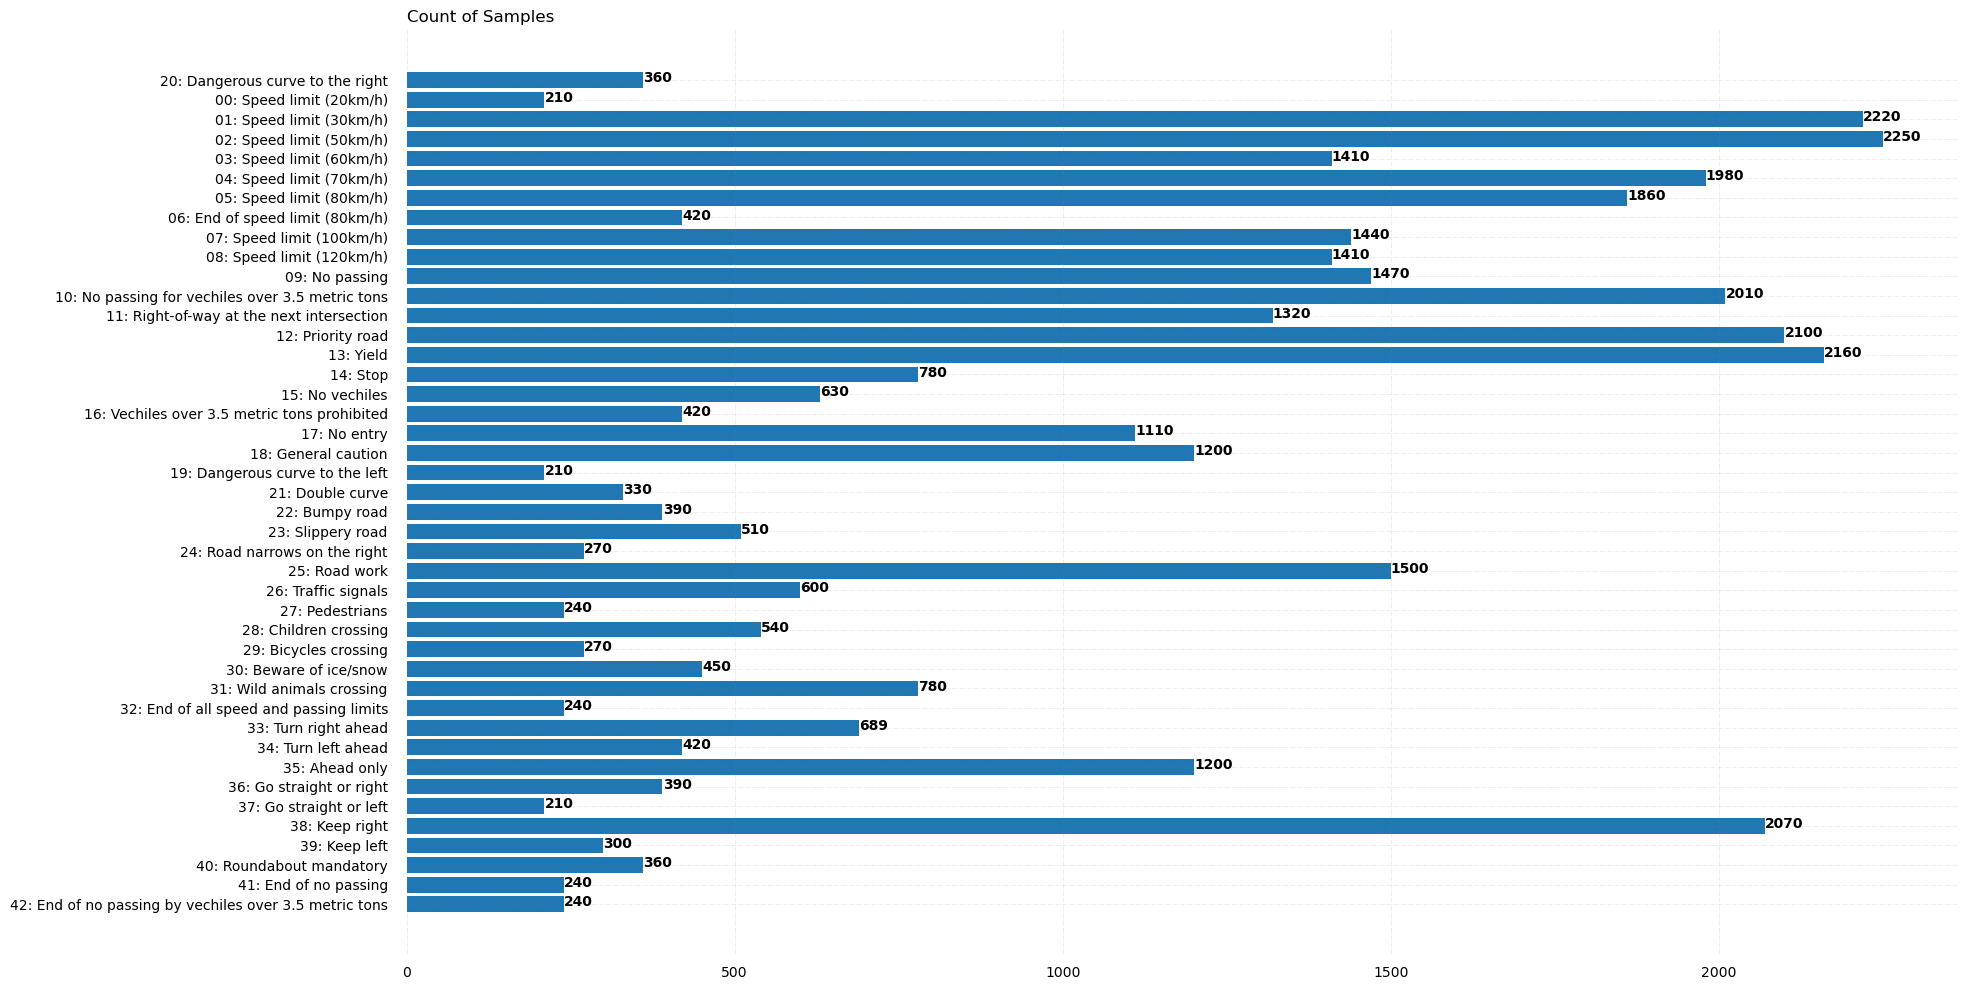

In [14]:
ccount = list(class_img_count.values())
cla = list(class_img_count.keys())

fig, ax = plt.subplots(figsize =(20, 12))

plt.barh(cla, ccount)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
ax.grid(visible=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='black')

ax.set_title('Count of Samples',   loc ='left' )


### 5.2 Visualizing 10 randomely picked color images from training set.

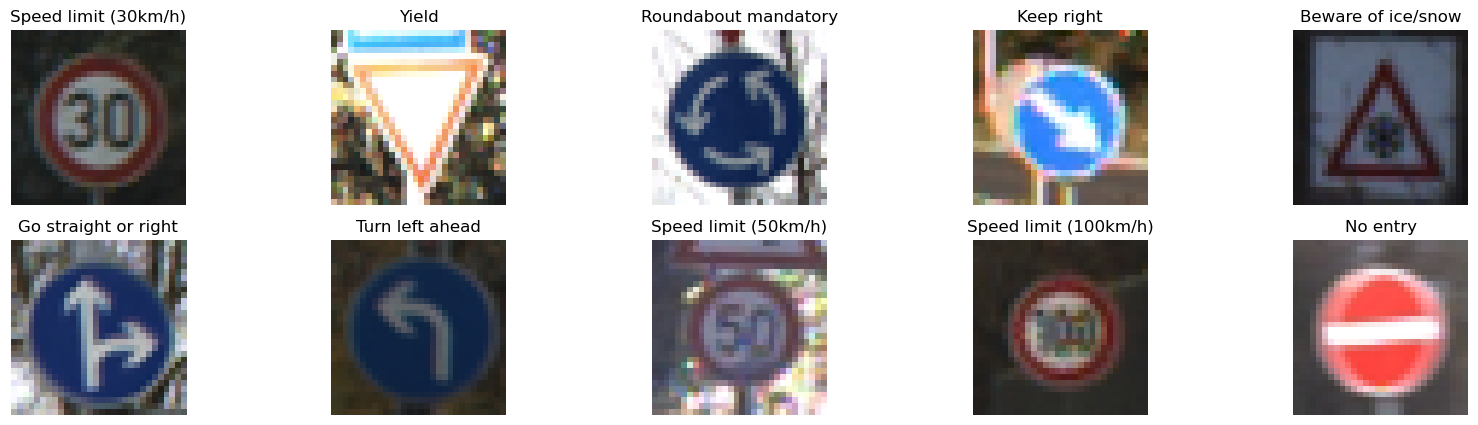

In [19]:
# visualize 10 images in color-image dataset 
test_data_len = len(color_img_arr)
fig, axes = plt.subplots(2,5, figsize=(20,5))
for i,ax in enumerate(axes.flat):
    test_data_index = np.random.randint(test_data_len)  
    ax.imshow(color_img_arr[test_data_index])
    ax.grid(False)
    ax.axis('off')
    ax.set_title(get_Class_Name(train_label_arr[test_data_index]))

### 5.3 Visualizing 10 randomely picked grayscale images from training set.

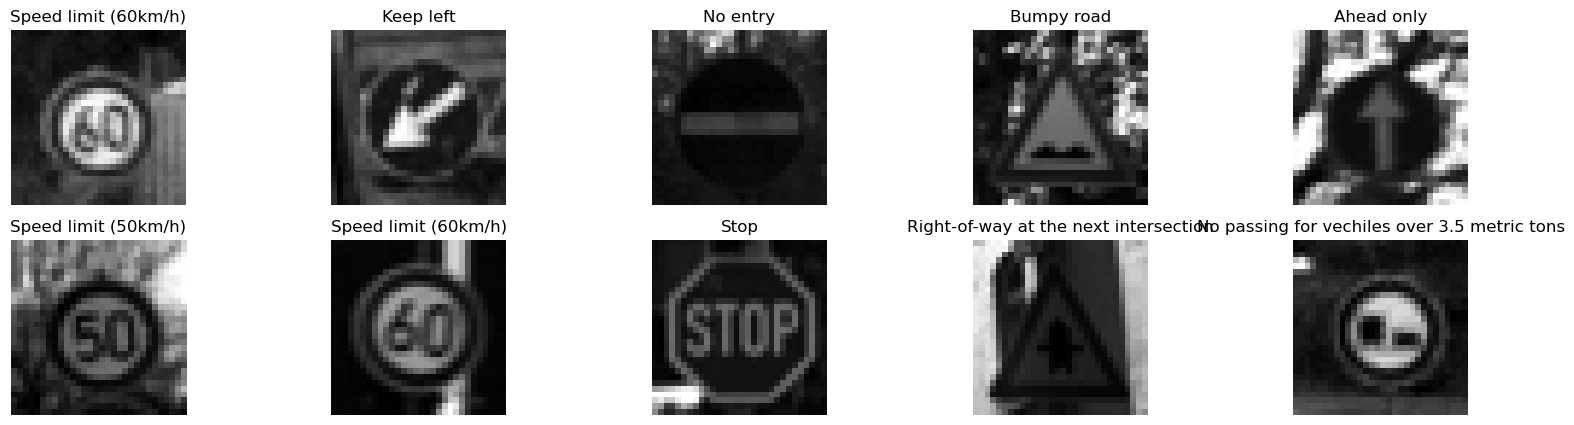

In [20]:
# visualize 10 images in grayscale-images dataset 
test_data_len = len(color_img_arr)
fig, axes = plt.subplots(2,5, figsize=(20,5))
for i,ax in enumerate(axes.flat):
    test_data_index = np.random.randint(test_data_len)     
    ax.imshow(grayscale_img_arr[test_data_index], cmap='gray')
    ax.grid(False)
    ax.axis('off')
    ax.set_title(get_Class_Name(train_label_arr[test_data_index]))

## 6. Deep CNN Model

### 6.1 Build Deep Learning Model

In [23]:
def build_And_Train_Model(train_image_arr, is_img_color):
	''' 
	Build and train a sequential model to classifying the images into 43 classes.
	'''
	val_accuracy_arr = []
	val_loss_arr = []
	
	len_of_label = len(train_label_arr) # the length of the train dataset
	no_epochs = 5
	img_type = 'col' if is_img_color else 'gry' # set colormap of the plot based on image type

	kf = KFold(n_splits=5, shuffle=True, random_state=43)
	fold_var = 1
	# Randomize the order of the input images and split data into train and validation
	for train_index, val_index in kf.split(np.zeros(len_of_label), train_label_arr):
		
		# Split data into train and validation
		(X_train, X_val) = train_image_arr[train_index], train_image_arr[val_index]	
		(y_train, y_val) = train_label_arr[train_index], train_label_arr[val_index]

		# Using one hote encoding for the train and validation labels
		y_train = to_categorical(y_train, 43)
		y_val = to_categorical(y_val, 43)

		# get complied model specific to image type
		model = get_Compiled_Sequential_Model(is_img_color)

		# get callbacks as list that are intialized based on the param 
		callbacks_arr = get_All_Callbacks(fold_var, img_type)
		
		# Train the classifier.
		history = model.fit(X_train, y_train, batch_size=32, 
		      epochs=no_epochs,
		      validation_data=(X_val, y_val),
			  callbacks = callbacks_arr)

		#PLOT HISTORY
		plot_Accuracy_And_Loss_History(history)

		# LOAD BEST MODEL to evaluate the performance of the model
		model.load_weights(os.path.join(model_dir, get_Model_Name(fold_var, img_type)))
		
		# Evaluate the model on the test data using `evaluate`
		results = model.evaluate(X_val, y_val, batch_size=32)
		results = dict(zip(model.metrics_names, results))

		# Save the evaluation result metrics 
		val_accuracy_arr.append(results['accuracy'])
		val_loss_arr.append(results['loss'])
		
		tf.keras.backend.clear_session()
		
		fold_var += 1

	# Retrun best of best n(fold_var) model evaluation result metrics
	return val_accuracy_arr, val_loss_arr

### 6.2 Train color image classifire model

Epoch 1/5
981/981 [==============================] - ETA: 0s - loss: 1.1038 - accuracy: 0.6907
Epoch 1: val_accuracy improved from -inf to 0.96251, saving model to Models\Traffic_cla_model_1_col.h5
981/981 [==============================] - 424s 425ms/step - loss: 1.1038 - accuracy: 0.6907 - val_loss: 0.1638 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 2/5
981/981 [==============================] - ETA: 0s - loss: 0.1977 - accuracy: 0.9404
Epoch 2: val_accuracy improved from 0.96251 to 0.98699, saving model to Models\Traffic_cla_model_1_col.h5
981/981 [==============================] - 400s 408ms/step - loss: 0.1977 - accuracy: 0.9404 - val_loss: 0.0567 - val_accuracy: 0.9870 - lr: 0.0010
Epoch 3/5
981/981 [==============================] - ETA: 0s - loss: 0.1192 - accuracy: 0.9658
Epoch 3: val_accuracy improved from 0.98699 to 0.98916, saving model to Models\Traffic_cla_model_1_col.h5
981/981 [==============================] - 385s 393ms/step - loss: 0.1192 - accuracy: 0.9658 - val_loss:

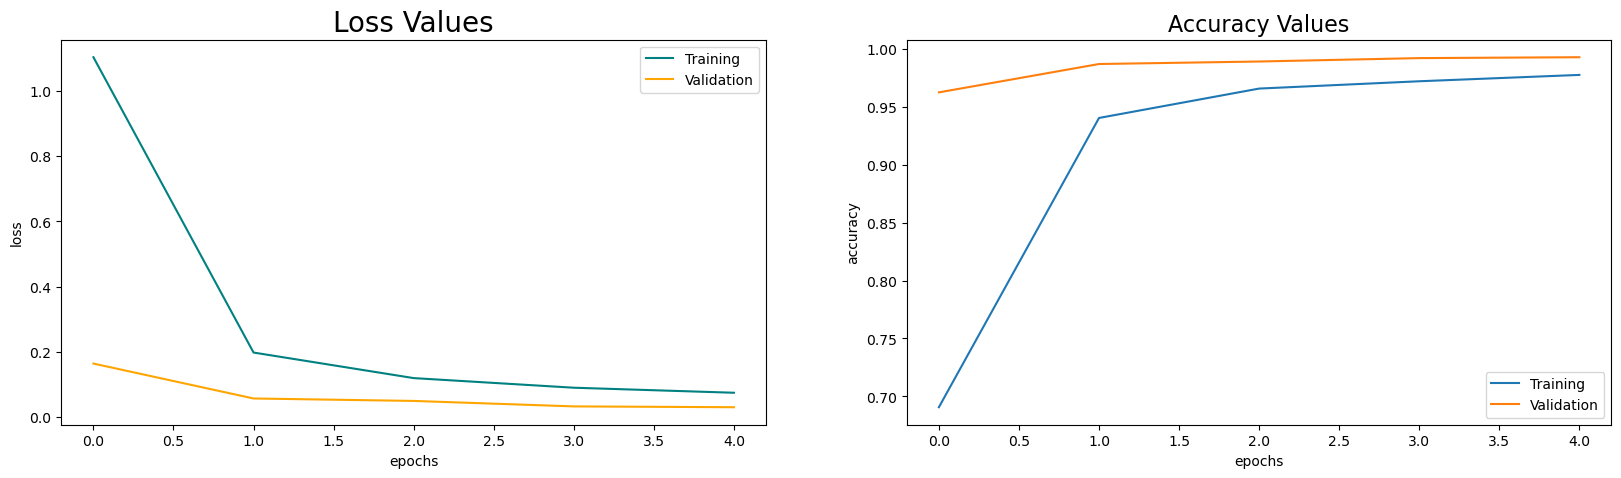

246/246 [==============================] - 35s 144ms/step - loss: 0.0299 - accuracy: 0.9929
Epoch 1/5
981/981 [==============================] - ETA: 0s - loss: 1.1453 - accuracy: 0.6742
Epoch 1: val_accuracy improved from -inf to 0.97207, saving model to Models\Traffic_cla_model_2_col.h5
981/981 [==============================] - 369s 371ms/step - loss: 1.1453 - accuracy: 0.6742 - val_loss: 0.1268 - val_accuracy: 0.9721 - lr: 0.0010
Epoch 2/5
981/981 [==============================] - ETA: 0s - loss: 0.2036 - accuracy: 0.9384
Epoch 2: val_accuracy improved from 0.97207 to 0.98789, saving model to Models\Traffic_cla_model_2_col.h5
981/981 [==============================] - 364s 371ms/step - loss: 0.2036 - accuracy: 0.9384 - val_loss: 0.0537 - val_accuracy: 0.9879 - lr: 0.0010
Epoch 3/5
981/981 [==============================] - ETA: 0s - loss: 0.1260 - accuracy: 0.9622
Epoch 3: val_accuracy improved from 0.98789 to 0.99311, saving model to Models\Traffic_cla_model_2_col.h5
981/981 [===

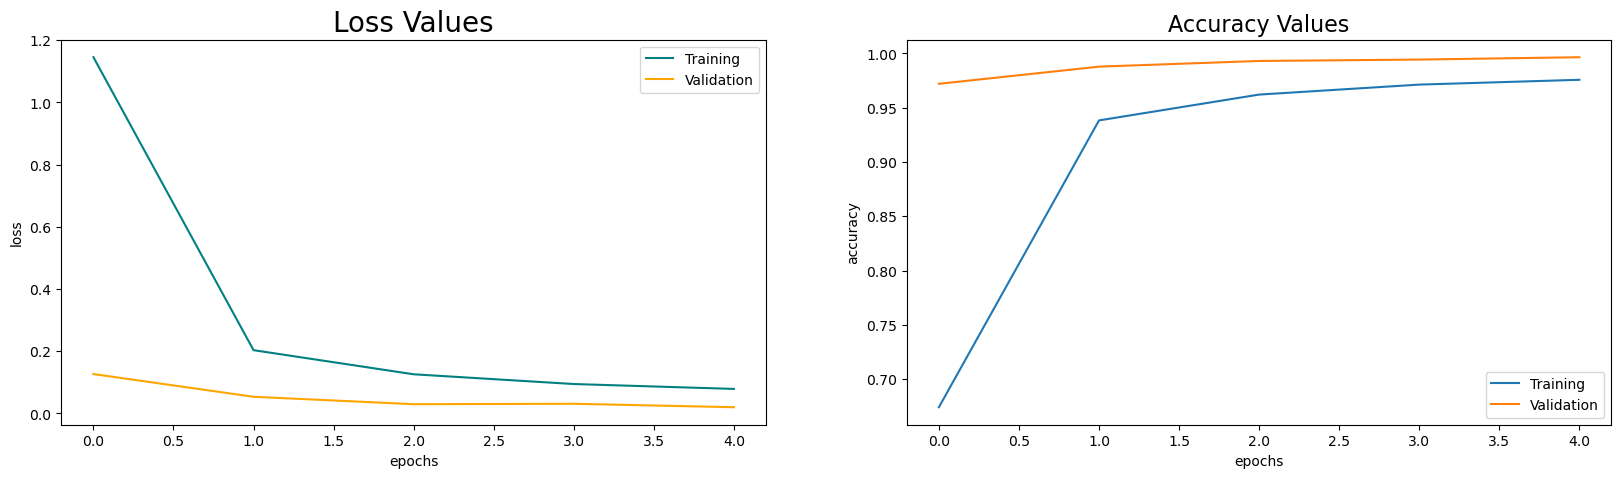

246/246 [==============================] - 34s 140ms/step - loss: 0.0202 - accuracy: 0.9966
Epoch 1/5
981/981 [==============================] - ETA: 0s - loss: 1.2594 - accuracy: 0.6421
Epoch 1: val_accuracy improved from -inf to 0.96634, saving model to Models\Traffic_cla_model_3_col.h5
981/981 [==============================] - 380s 384ms/step - loss: 1.2594 - accuracy: 0.6421 - val_loss: 0.1356 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 2/5
981/981 [==============================] - ETA: 0s - loss: 0.2357 - accuracy: 0.9296
Epoch 2: val_accuracy improved from 0.96634 to 0.98432, saving model to Models\Traffic_cla_model_3_col.h5
981/981 [==============================] - 359s 366ms/step - loss: 0.2357 - accuracy: 0.9296 - val_loss: 0.0653 - val_accuracy: 0.9843 - lr: 0.0010
Epoch 3/5
981/981 [==============================] - ETA: 0s - loss: 0.1474 - accuracy: 0.9551
Epoch 3: val_accuracy improved from 0.98432 to 0.98967, saving model to Models\Traffic_cla_model_3_col.h5
981/981 [===

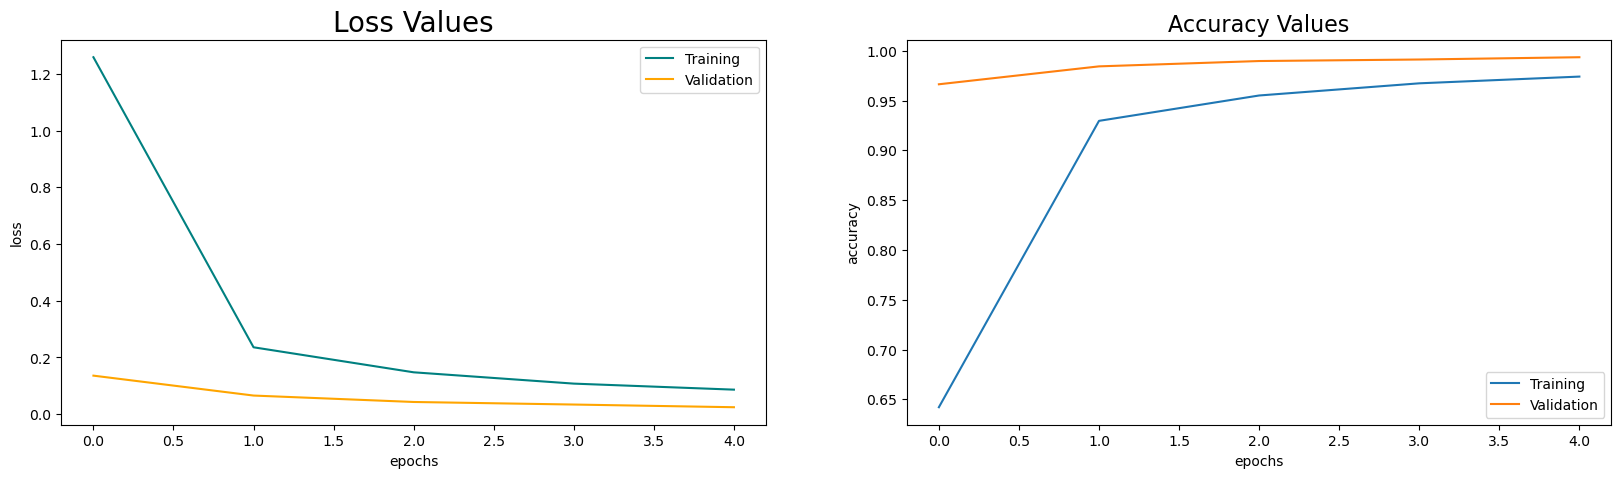

246/246 [==============================] - 35s 142ms/step - loss: 0.0241 - accuracy: 0.9935
Epoch 1/5
981/981 [==============================] - ETA: 0s - loss: 1.1763 - accuracy: 0.6697
Epoch 1: val_accuracy improved from -inf to 0.97450, saving model to Models\Traffic_cla_model_4_col.h5
981/981 [==============================] - 397s 400ms/step - loss: 1.1763 - accuracy: 0.6697 - val_loss: 0.1421 - val_accuracy: 0.9745 - lr: 0.0010
Epoch 2/5
981/981 [==============================] - ETA: 0s - loss: 0.2146 - accuracy: 0.9353
Epoch 2: val_accuracy improved from 0.97450 to 0.98610, saving model to Models\Traffic_cla_model_4_col.h5
981/981 [==============================] - 416s 425ms/step - loss: 0.2146 - accuracy: 0.9353 - val_loss: 0.0485 - val_accuracy: 0.9861 - lr: 0.0010
Epoch 3/5
981/981 [==============================] - ETA: 0s - loss: 0.1294 - accuracy: 0.9607
Epoch 3: val_accuracy improved from 0.98610 to 0.99401, saving model to Models\Traffic_cla_model_4_col.h5
981/981 [===

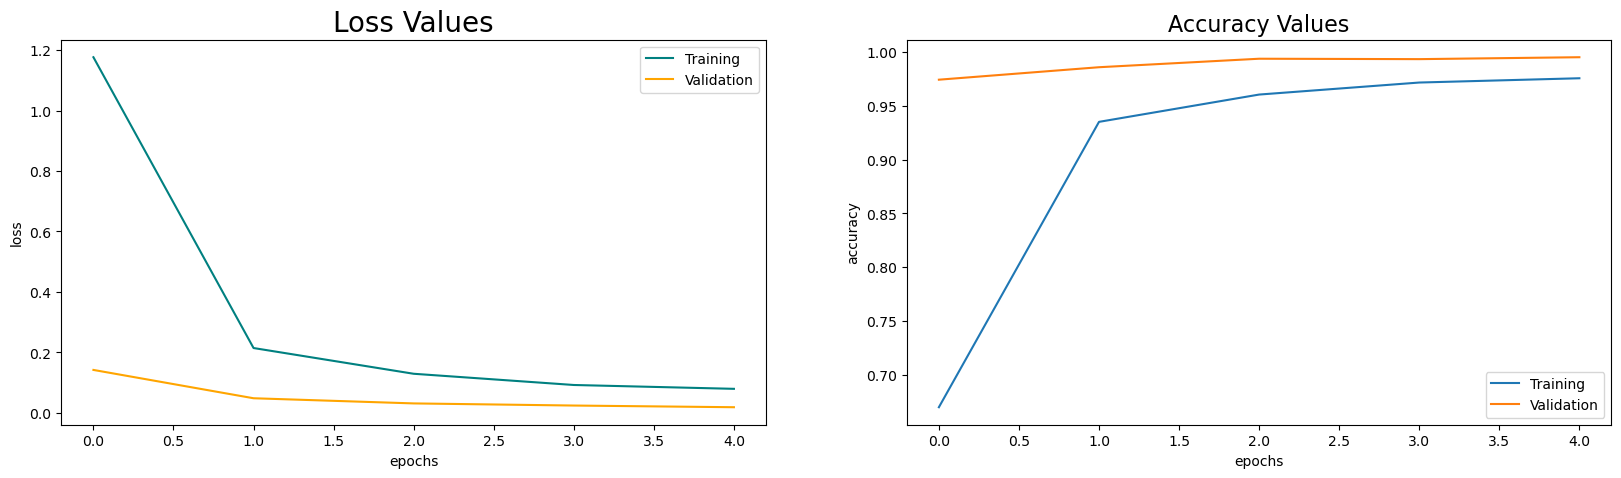

246/246 [==============================] - 34s 139ms/step - loss: 0.0188 - accuracy: 0.9954
Epoch 1/5
981/981 [==============================] - ETA: 0s - loss: 1.1686 - accuracy: 0.6716
Epoch 1: val_accuracy improved from -inf to 0.96301, saving model to Models\Traffic_cla_model_5_col.h5
981/981 [==============================] - 365s 368ms/step - loss: 1.1686 - accuracy: 0.6716 - val_loss: 0.1363 - val_accuracy: 0.9630 - lr: 0.0010
Epoch 2/5
981/981 [==============================] - ETA: 0s - loss: 0.2309 - accuracy: 0.9301
Epoch 2: val_accuracy improved from 0.96301 to 0.98814, saving model to Models\Traffic_cla_model_5_col.h5
981/981 [==============================] - 395s 402ms/step - loss: 0.2309 - accuracy: 0.9301 - val_loss: 0.0488 - val_accuracy: 0.9881 - lr: 0.0010
Epoch 3/5
981/981 [==============================] - ETA: 0s - loss: 0.1426 - accuracy: 0.9557
Epoch 3: val_accuracy improved from 0.98814 to 0.99299, saving model to Models\Traffic_cla_model_5_col.h5
981/981 [===

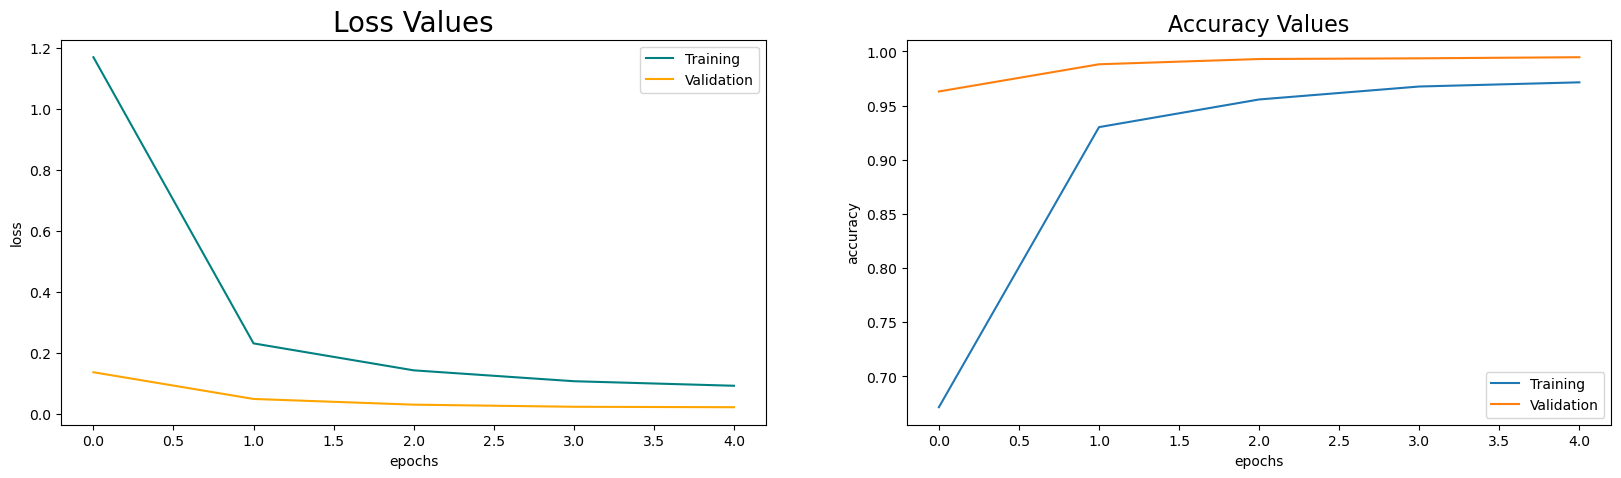

246/246 [==============================] - 49s 197ms/step - loss: 0.0217 - accuracy: 0.9946


In [34]:
# Build and train a model to classify color image
val_accuracy_arr, val_loss_arr = build_And_Train_Model(color_img_arr, True)

color_model_evaluation = pd.DataFrame(data =zip(val_accuracy_arr,val_loss_arr), columns=['Acc','Loss'])

### 6.3 Train grayscale image classifire model

Epoch 1/5
981/981 [==============================] - ETA: 0s - loss: 1.2417 - accuracy: 0.6527
Epoch 1: val_accuracy improved from -inf to 0.96289, saving model to Models\Traffic_cla_model_1_gry.h5
981/981 [==============================] - 360s 363ms/step - loss: 1.2417 - accuracy: 0.6527 - val_loss: 0.1578 - val_accuracy: 0.9629 - lr: 0.0010
Epoch 2/5
981/981 [==============================] - ETA: 0s - loss: 0.2419 - accuracy: 0.9273
Epoch 2: val_accuracy improved from 0.96289 to 0.98368, saving model to Models\Traffic_cla_model_1_gry.h5
981/981 [==============================] - 345s 351ms/step - loss: 0.2419 - accuracy: 0.9273 - val_loss: 0.0637 - val_accuracy: 0.9837 - lr: 0.0010
Epoch 3/5
981/981 [==============================] - ETA: 0s - loss: 0.1437 - accuracy: 0.9560
Epoch 3: val_accuracy improved from 0.98368 to 0.98967, saving model to Models\Traffic_cla_model_1_gry.h5
981/981 [==============================] - 352s 359ms/step - loss: 0.1437 - accuracy: 0.9560 - val_loss:

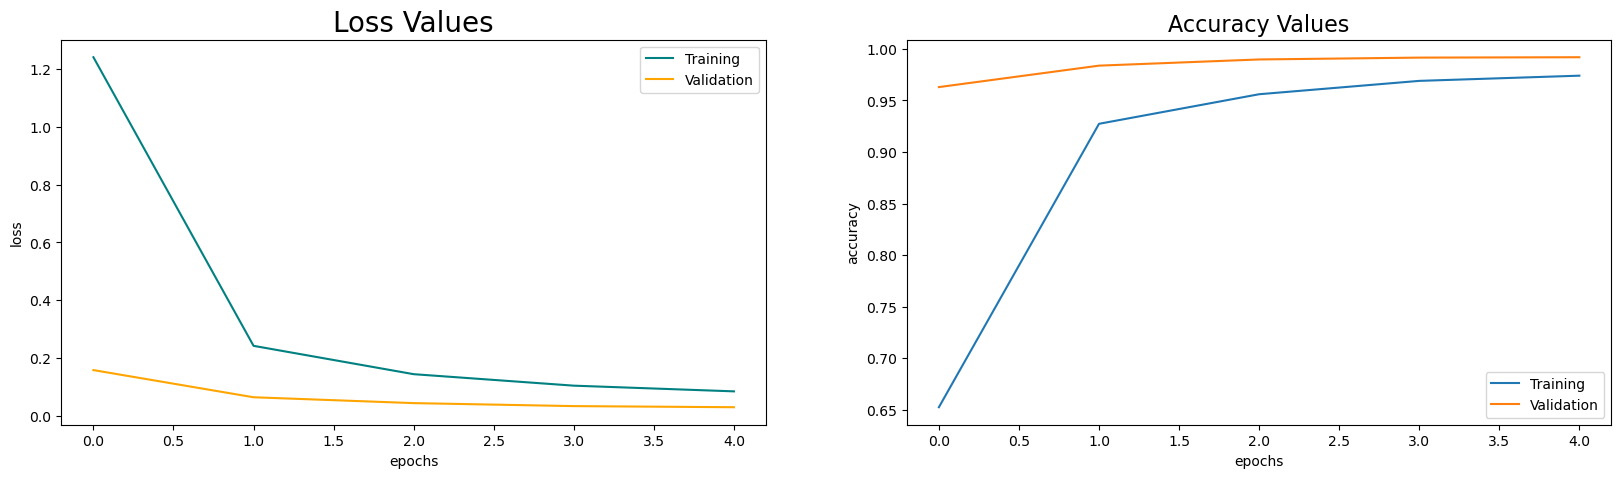

246/246 [==============================] - 37s 148ms/step - loss: 0.0292 - accuracy: 0.9918
Epoch 1/5
981/981 [==============================] - ETA: 0s - loss: 1.4745 - accuracy: 0.5904
Epoch 1: val_accuracy improved from -inf to 0.94823, saving model to Models\Traffic_cla_model_2_gry.h5
981/981 [==============================] - 354s 357ms/step - loss: 1.4745 - accuracy: 0.5904 - val_loss: 0.2039 - val_accuracy: 0.9482 - lr: 0.0010
Epoch 2/5
981/981 [==============================] - ETA: 0s - loss: 0.3094 - accuracy: 0.9038
Epoch 2: val_accuracy improved from 0.94823 to 0.97360, saving model to Models\Traffic_cla_model_2_gry.h5
981/981 [==============================] - 359s 366ms/step - loss: 0.3094 - accuracy: 0.9038 - val_loss: 0.1096 - val_accuracy: 0.9736 - lr: 0.0010
Epoch 3/5
981/981 [==============================] - ETA: 0s - loss: 0.1864 - accuracy: 0.9426
Epoch 3: val_accuracy improved from 0.97360 to 0.98852, saving model to Models\Traffic_cla_model_2_gry.h5
981/981 [===

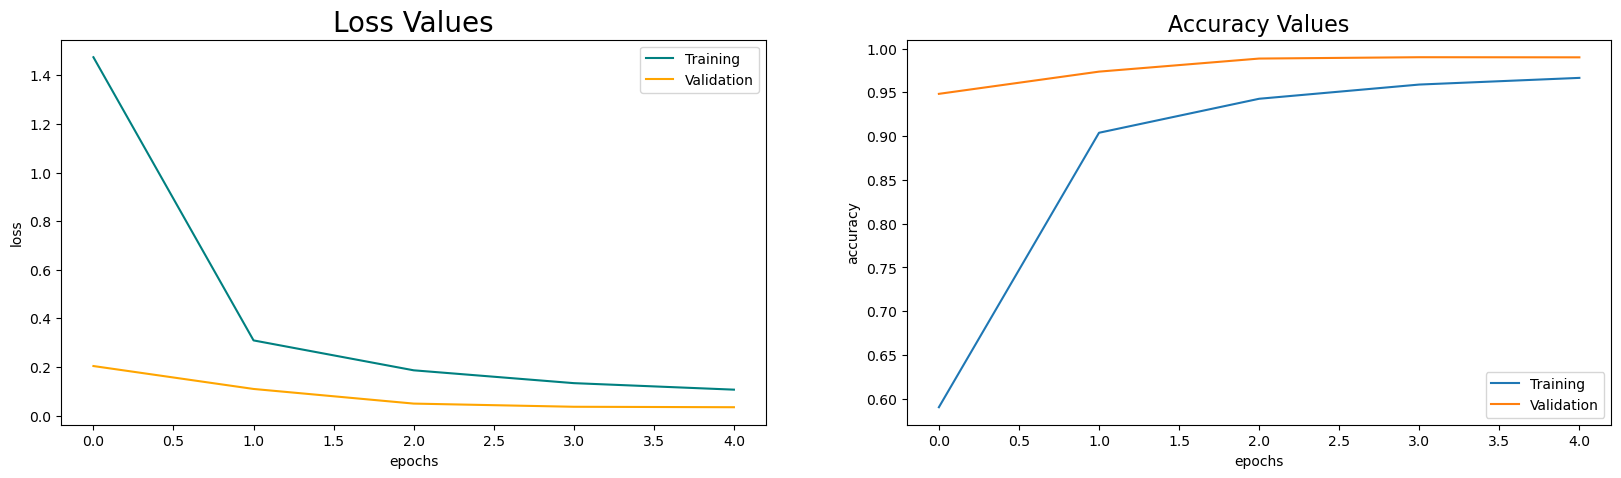

246/246 [==============================] - 33s 135ms/step - loss: 0.0363 - accuracy: 0.9901
Epoch 1/5
981/981 [==============================] - ETA: 0s - loss: 1.3267 - accuracy: 0.6312
Epoch 1: val_accuracy improved from -inf to 0.94912, saving model to Models\Traffic_cla_model_3_gry.h5
981/981 [==============================] - 353s 356ms/step - loss: 1.3267 - accuracy: 0.6312 - val_loss: 0.1885 - val_accuracy: 0.9491 - lr: 0.0010
Epoch 2/5
981/981 [==============================] - ETA: 0s - loss: 0.2739 - accuracy: 0.9163
Epoch 2: val_accuracy improved from 0.94912 to 0.98189, saving model to Models\Traffic_cla_model_3_gry.h5
981/981 [==============================] - 349s 355ms/step - loss: 0.2739 - accuracy: 0.9163 - val_loss: 0.0732 - val_accuracy: 0.9819 - lr: 0.0010
Epoch 3/5
981/981 [==============================] - ETA: 0s - loss: 0.1687 - accuracy: 0.9488
Epoch 3: val_accuracy improved from 0.98189 to 0.98674, saving model to Models\Traffic_cla_model_3_gry.h5
981/981 [===

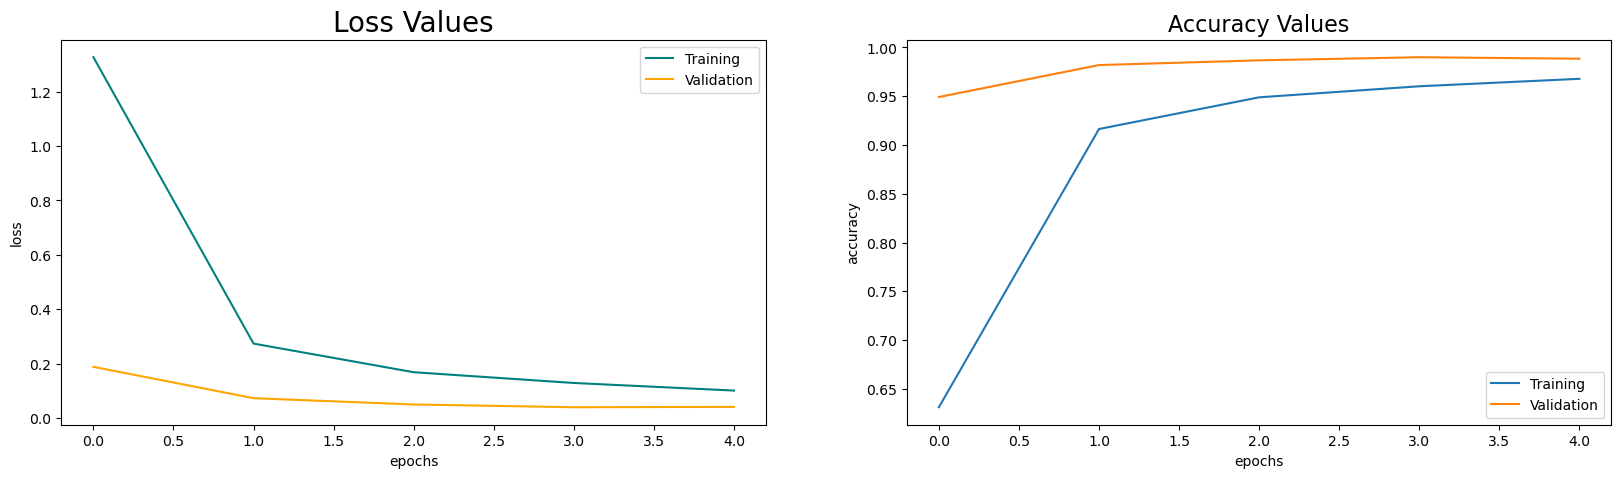

246/246 [==============================] - 33s 135ms/step - loss: 0.0400 - accuracy: 0.9899
Epoch 1/5
981/981 [==============================] - ETA: 0s - loss: 1.3283 - accuracy: 0.6333
Epoch 1: val_accuracy improved from -inf to 0.96111, saving model to Models\Traffic_cla_model_4_gry.h5
981/981 [==============================] - 356s 358ms/step - loss: 1.3283 - accuracy: 0.6333 - val_loss: 0.1524 - val_accuracy: 0.9611 - lr: 0.0010
Epoch 2/5
981/981 [==============================] - ETA: 0s - loss: 0.2578 - accuracy: 0.9236
Epoch 2: val_accuracy improved from 0.96111 to 0.98814, saving model to Models\Traffic_cla_model_4_gry.h5
981/981 [==============================] - 358s 364ms/step - loss: 0.2578 - accuracy: 0.9236 - val_loss: 0.0538 - val_accuracy: 0.9881 - lr: 0.0010
Epoch 3/5
981/981 [==============================] - ETA: 0s - loss: 0.1529 - accuracy: 0.9531
Epoch 3: val_accuracy did not improve from 0.98814
981/981 [==============================] - 352s 359ms/step - loss: 

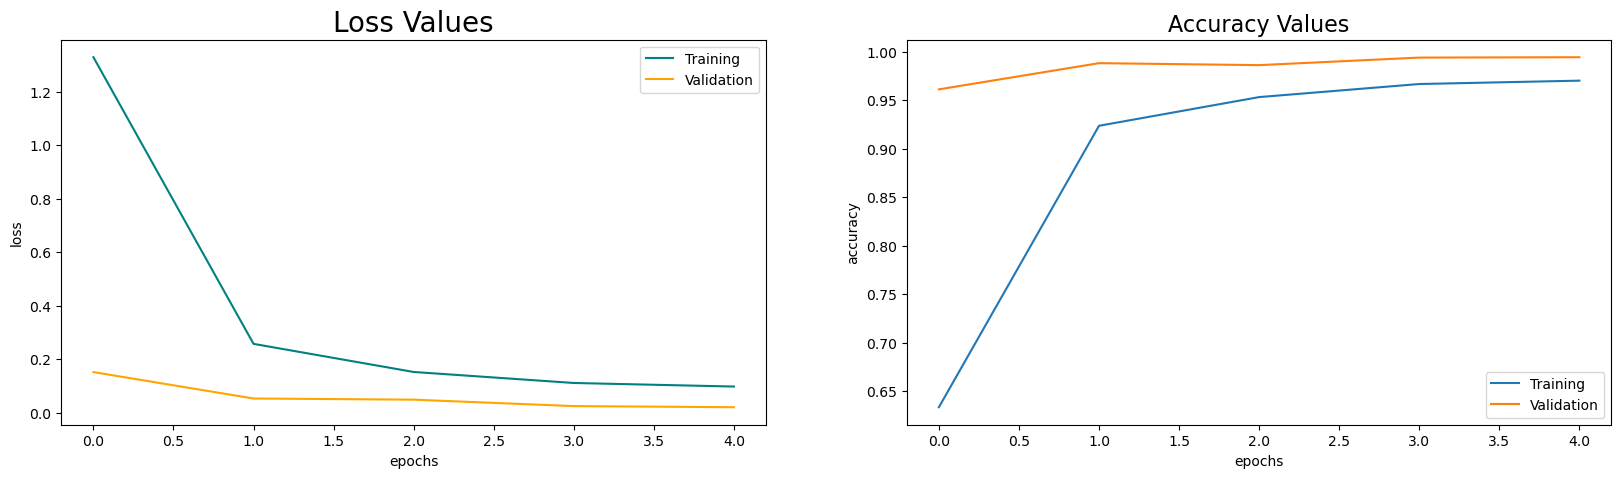

246/246 [==============================] - 35s 140ms/step - loss: 0.0213 - accuracy: 0.9943
Epoch 1/5
981/981 [==============================] - ETA: 0s - loss: 1.2111 - accuracy: 0.6626
Epoch 1: val_accuracy improved from -inf to 0.97258, saving model to Models\Traffic_cla_model_5_gry.h5
981/981 [==============================] - 353s 356ms/step - loss: 1.2111 - accuracy: 0.6626 - val_loss: 0.1276 - val_accuracy: 0.9726 - lr: 0.0010
Epoch 2/5
981/981 [==============================] - ETA: 0s - loss: 0.2269 - accuracy: 0.9311
Epoch 2: val_accuracy improved from 0.97258 to 0.98827, saving model to Models\Traffic_cla_model_5_gry.h5
981/981 [==============================] - 350s 357ms/step - loss: 0.2269 - accuracy: 0.9311 - val_loss: 0.0509 - val_accuracy: 0.9883 - lr: 0.0010
Epoch 3/5
981/981 [==============================] - ETA: 0s - loss: 0.1346 - accuracy: 0.9599
Epoch 3: val_accuracy improved from 0.98827 to 0.99286, saving model to Models\Traffic_cla_model_5_gry.h5
981/981 [===

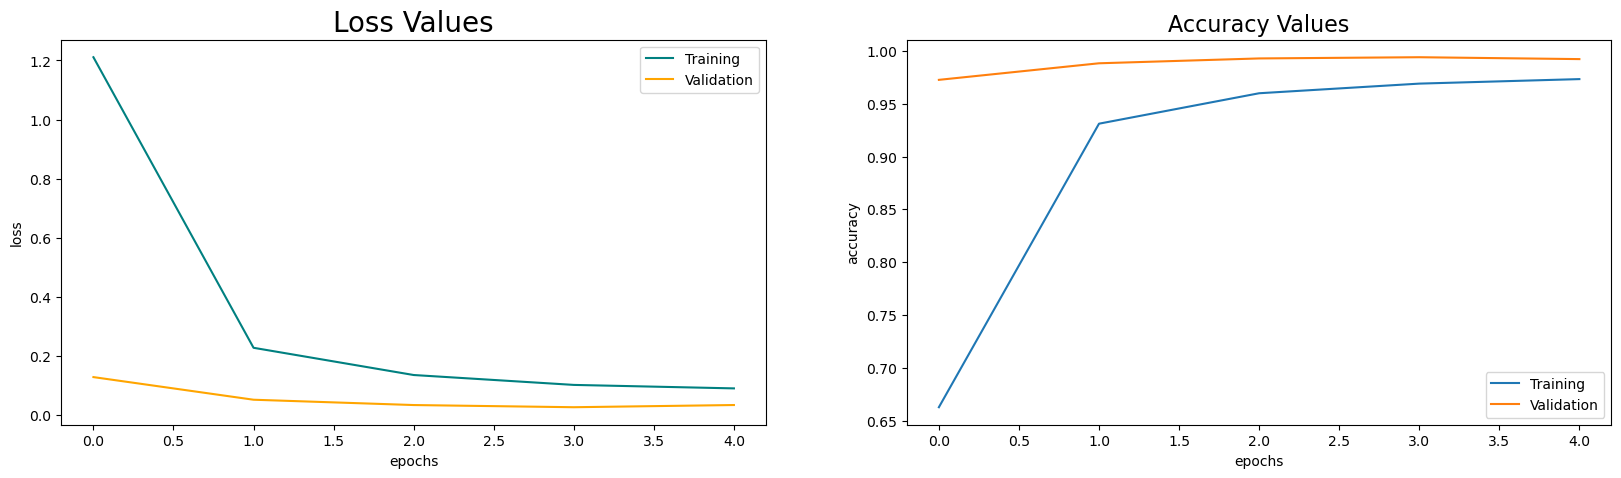

246/246 [==============================] - 34s 139ms/step - loss: 0.0255 - accuracy: 0.9940


In [36]:
# Build and train a model to classify grayscale image
val_accuracy_arr, val_loss_arr = build_And_Train_Model(grayscale_img_arr, False)

grayscale_model_evaluation = pd.DataFrame(data =zip(val_accuracy_arr,val_loss_arr), columns=['Acc','Loss'])

## 7. Evaluate Model Performance

### 7.1 Define function predicting with the test data

In [9]:
# Predicting with the test data
def do_Predict_with_Test_Data(model, X_test, y_test):
    '''' 
    Use the model to predict the values from the test dataset.

    arg:
    ---
    model: object
        Image classifier sequential model
    X_test: (array, shape = [n, n] or [n,n,3])
        Numpy array of tset dataset
    y_tset: (array, shape = [n])
        Numpy array of tset dataset values
    '''

    test_data_len = X_test.shape[0]
    # get the dimension of the images array color(1,30 30,3) or grayscale(1,30 30,1)
    arr_dimension =  (1,) + image_size + (3,) if len(X_test.shape) == 4 else (1,) + image_size + (1,)
    # select the colormap of the plot color=viridis or grayscale=gray
    color_map = 'viridis' if len(X_test.shape) == 4 else 'gray'
    fig, axes = plt.subplots(3,6, figsize=(20,8))

    for i, ax in enumerate(axes.flat):
        # Pick randomly index of an image from test dataset
        test_data_index = np.random.randint(test_data_len)        
        # Use the model to predict the value of randomly picked image from the test dataset.
        predicted = np.argmax(model.predict(X_test[test_data_index].reshape(arr_dimension)))
        # original value of randomly picked image from the test dataset.
        original  = y_test[test_data_index]
        # Plot randomly picked image
        ax.imshow(X_test[test_data_index], cmap=color_map)
        ax.grid(False)
        ax.axis('off')    
        ax.set_title(f'Original: {original} Predicted: {predicted}')

### 7.2 Loading the test images

In [10]:
# Reading the test images and putting them into a list
X_test_color    = []  # a list to store testing color images
X_test_gryscale = []  # a list to store testing greyscale images
y_test_col_gry  = []  # a list to store testing image lables 

# loop through the test dataset and load the image from file
for dt_label in ds_test_data_label.values:
    img_path = os.path.join(path_test_data, dt_label[1].replace('Test/', ''))
    img_col, img_gry = load_Color_and_Grayscale_Image(img_path)
    
    X_test_color.append(img_col)
    X_test_gryscale.append(img_gry)

    y_test_col_gry.append(dt_label[0])

In [12]:
# Converting the test images and putting them into a numpy array
X_test_color    = np.array(X_test_color)
X_test_gryscale = np.array(X_test_gryscale)
y_test_col_gry  = np.asarray(y_test_col_gry)

In [13]:
# Examine the shape of testing data:
print("Color Image Shape: ", X_test_color[0].shape)
print("Grayscale Image Shape: ", X_test_gryscale[0].shape)

Color Image Shape:  (30, 30, 3)
Grayscale Image Shape:  (30, 30)


### 7.3 Loading a saved model from file

In [18]:
# load a saved color image classifire model from file
color_model = load_model('Models/Traffic_cla_model_2_col.h5') 

# load a saved grayscale image classifire model from file
grayscale_model = load_model('Models/Traffic_cla_model_5_gry.h5') 

### 7.4 Predicting with the color test data

1/1 [==============================] - 0s 77ms/step


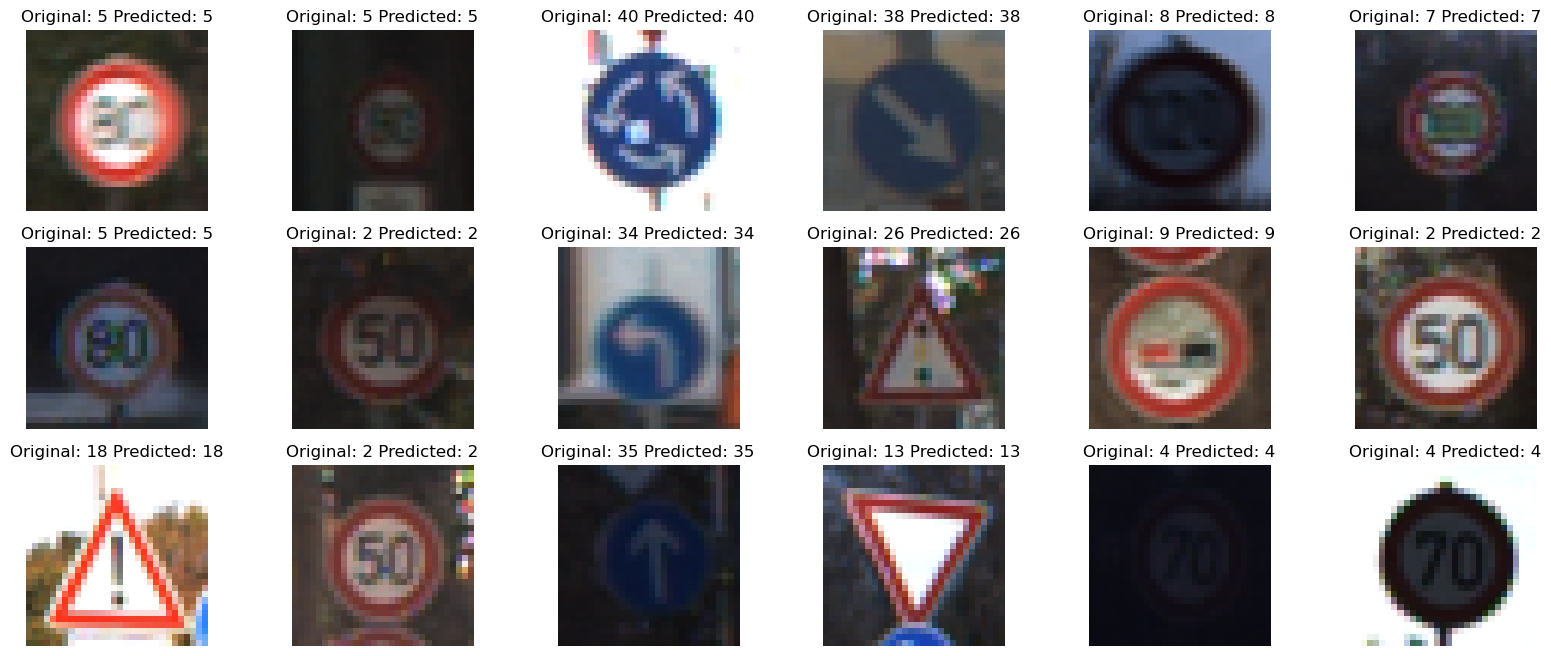

In [41]:
# Predicting using color-image classifire model with the test data
do_Predict_with_Test_Data(color_model, X_test_color, y_test_col_gry)

### 7.5 Predicting with the grayscale test data

1/1 [==============================] - 0s 66ms/step


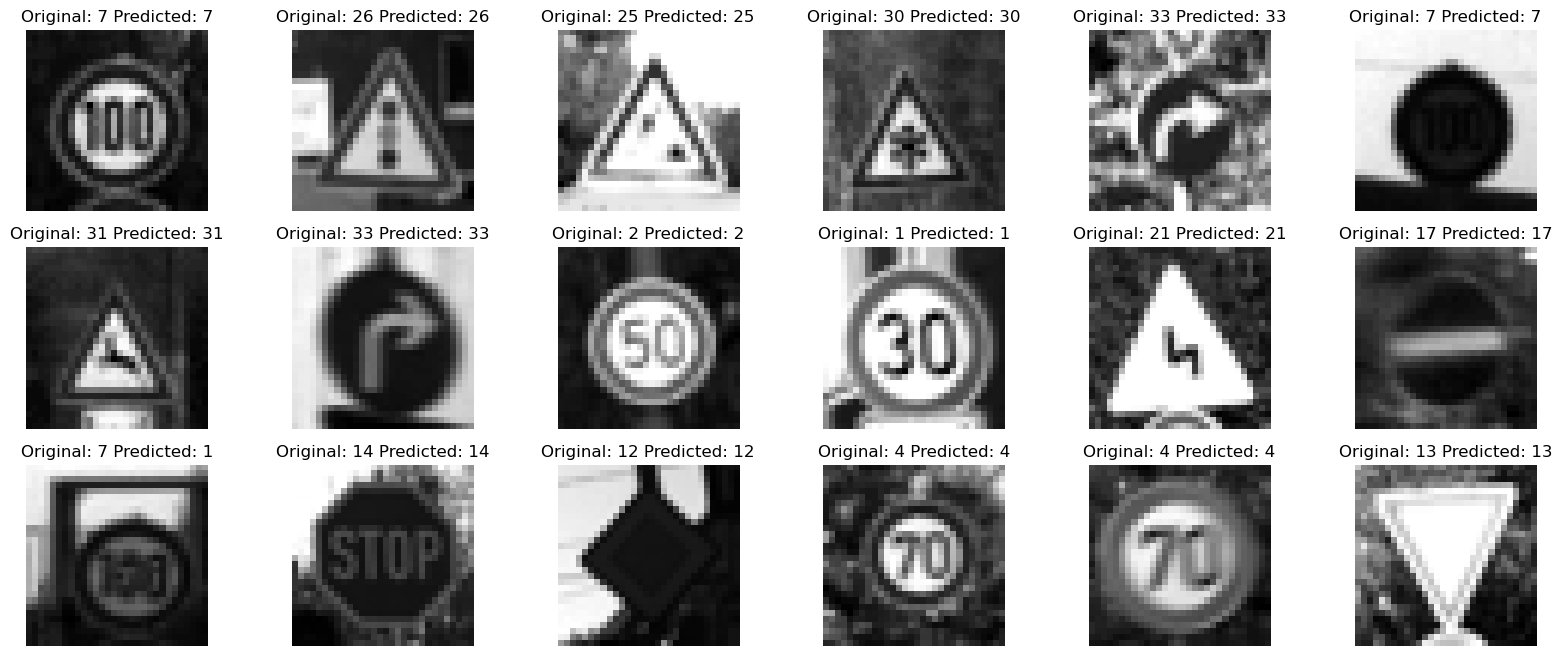

In [16]:
# Predicting using grayscale image classifire model with the test data
do_Predict_with_Test_Data(grayscale_model, X_test_gryscale, y_test_col_gry)

### 7.6 Observe the precision, recall the F1-score for all classes for color models

In [15]:
# Generate precision, recall the F1-score report on test data using `predict`
def get_Classification_Report(model, X_test, y_test):
    #make both class and probability predictions
    y_predicted = model.predict(X_test, batch_size=32, verbose=0)
    y_classes = np.argmax(y_predicted, axis=1)

    return classification_report(y_test, y_classes)

In [44]:
# get precision, recall the F1-score report of color model
color_model_report = get_Classification_Report(color_model,X_test_color,y_test_col_gry)


In [45]:
# print color model precision, recall the F1-score report
print(color_model_report)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        60
           1       0.93      0.99      0.96       720
           2       0.99      0.98      0.99       750
           3       0.96      0.97      0.96       450
           4       0.99      0.98      0.99       660
           5       0.95      0.96      0.96       630
           6       1.00      0.75      0.85       150
           7       0.98      0.98      0.98       450
           8       0.97      0.98      0.98       450
           9       0.96      1.00      0.98       480
          10       1.00      0.99      1.00       660
          11       0.96      0.95      0.96       420
          12       0.99      0.97      0.98       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.91      1.00      0.95       210
          16       1.00      1.00      1.00       150
          17       1.00    

### 7.7 Observe the precision, recall the F1-score for all classes for grayscale models

In [19]:
# get precision, recall the F1-score report of grayscale model
grayscale_model_report = get_Classification_Report(grayscale_model,X_test_gryscale,y_test_col_gry)

In [20]:
# print grayscale model precision, recall the F1-score report
print(grayscale_model_report)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        60
           1       0.94      0.98      0.96       720
           2       0.97      0.99      0.98       750
           3       0.88      0.99      0.93       450
           4       0.99      0.97      0.98       660
           5       0.99      0.91      0.95       630
           6       1.00      0.84      0.91       150
           7       0.98      0.96      0.97       450
           8       0.95      0.98      0.97       450
           9       0.95      1.00      0.97       480
          10       1.00      0.98      0.99       660
          11       0.96      0.99      0.97       420
          12       0.94      0.98      0.96       690
          13       0.99      0.99      0.99       720
          14       1.00      0.99      0.99       270
          15       0.99      1.00      0.99       210
          16       1.00      0.99      0.99       150
          17       0.99    

### 7.8 Compare the color and grayscale models and analyze which model is better


Both models performed well, the models are achieved an accuracy rate of above 95%. But the color model have an accuracy rate better than the grayscale by 1%
<br>
<br>Color model accuracy rate : 97%
<br>Grayscale model accuracy rate : 96%
<br>
<br>To achive these accuracy rate I used the same CNN architechture for both models: 

*       [Conv2D -> relu]*2 
            -> MaxPool2D -> Dropout 
                -> Conv2D -> relu 
                    -> MaxPool2D -> Dropout
                        -> Flatten 
                            -> Dense -> Dropout -> softmax
